# SDSSJ1730+5545

In [7]:
import json,urllib
from zipfile import ZipFile
import glob, os
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
from lightkurve.lightcurve import LightCurve as LC
from lightkurve import TessTargetPixelFile

import eleanor

from bokeh.plotting import output_notebook, figure, show
from bokeh.models import HoverTool, tools,ColumnDataSource, Whisker, ColorBar, LinearColorMapper
from astropy.io import fits
output_notebook()



Loading BokehJS ...

In [8]:
name = 'SDSSJ1730+5545'
with open('response.json','r') as JSON:
    rdic = json.load(JSON)
sourcetess = rdic[name]

sourcetess['ra']
sourcecoord = "{} +{}".format(sourcetess['ra'],sourcetess['dec'])
print(sourcecoord)



lk.search_tesscut(sourcecoord)


262.69829166666665 +55.75513888888889


SearchResult containing 5 data products.

             target_name              productFilename         description         distance
------------------------------------- --------------- --------------------------- --------
262.69829166666665 +55.75513888888889             n/a TESS FFI Cutout (sector 14)      0.0
262.69829166666665 +55.75513888888889             n/a TESS FFI Cutout (sector 15)      0.0
262.69829166666665 +55.75513888888889             n/a TESS FFI Cutout (sector 16)      0.0
262.69829166666665 +55.75513888888889             n/a TESS FFI Cutout (sector 17)      0.0
262.69829166666665 +55.75513888888889             n/a TESS FFI Cutout (sector 18)      0.0

# First Sector

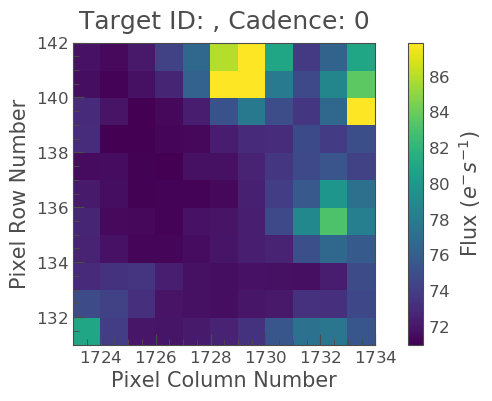

In [9]:
sectornum = 14
#tpf = lk.search_tesscut(sourcecoord,sector=sectornum).download(cutout_size=11)

url = "https://mast.stsci.edu/tesscut/api/v0.1/astrocut?ra={ra}&dec={dec}&y=11&x=11&units=px&sector={sector}".format(ra=sourcetess['ra']
,dec=sourcetess['dec']
,sector=sectornum)
#tpf = lk.search_tesscut(sourcecoord,sector=sectornum).download(cutout_size=11)
response = urllib.request.urlretrieve(url,'TESSCUT.zip')
with ZipFile('TESSCUT.zip') as zipobj:
    zipobj.extractall()
    
for i in glob.glob('tess-s*.fits'):
    os.rename(i,'astrocut.fits')
    tpf = lk.TessTargetPixelFile('astrocut.fits')
    os.remove('astrocut.fits')
    os.remove('TESSCUT.zip')
    



tpf.plot()

In [17]:
#If eleanor mask was found can do aperture_mask=data.aperture.astype(bool)

sourcelc = '{}Sector{}withBKLC.fits'.format(name,tpf.sector)
#tpf.interact(notebook_url='localhost:8888',exported_filename=sourcelc)
tpf.interact(notebook_url='localhost:8888',exported_filename=sourcelc,aperture_mask=np.flip(dataeleanor.aperture.astype(bool),0))

In [11]:
tpf.interact_sky(magnitude_limit=20)

In [14]:
background_mask = ~tpf.create_threshold_mask(threshold=0.0000001, reference_pixel=None)
#tpf.plot(aperture_mask=background_mask, mask_color='w');
n_background_pixels = background_mask.sum()
#print(n_background_pixels)
backgroundlc = '{}Sector{}BKLC.fits'.format(name,tpf.sector)

tpf.interact(notebook_url='localhost:8888',exported_filename=backgroundlc,aperture_mask=background_mask)

## Create a light-curve

Number of Background Pixels: 43


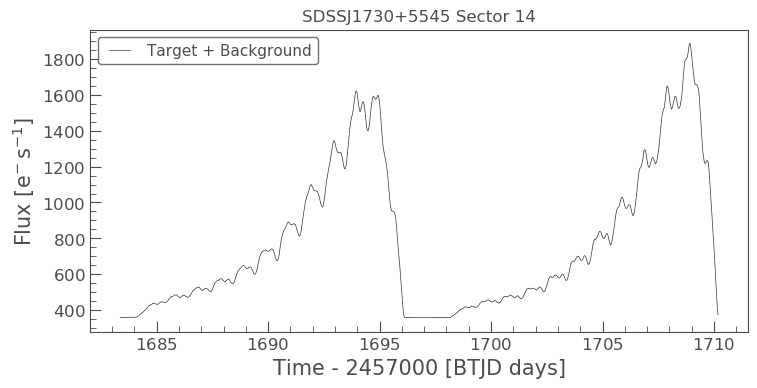

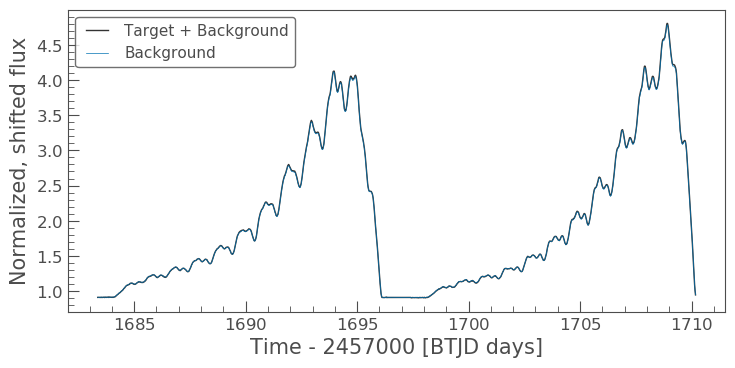

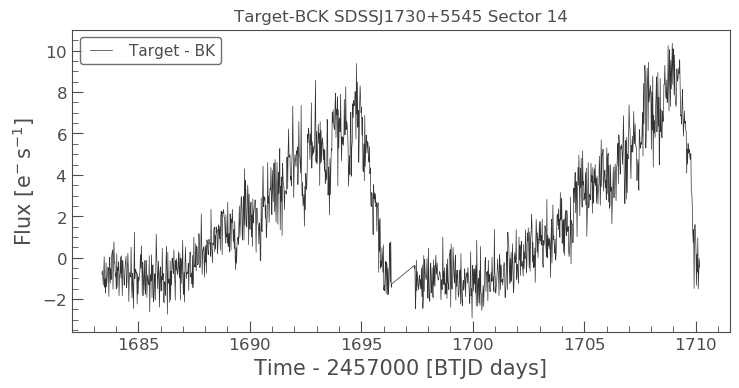

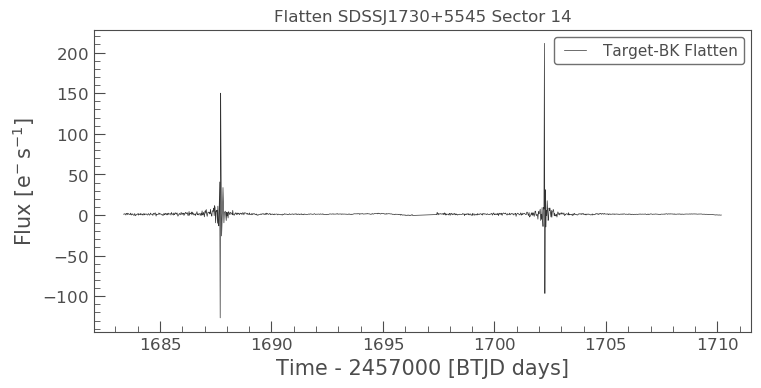

In [20]:
sourcemaskfits = fits.open(sourcelc)
sourcemask = sourcemaskfits[2].data
n_target_pixels = len(np.where(sourcemask==3)[0])

target_lc = tpf.to_lightcurve(aperture_mask=sourcemask)
target_lc.plot(label='Target + Background')
titleplot1 = '{} Sector {}'.format(name,sectornum)
plt.title(titleplot1)


#Backgorund
backgroundmaskfits = fits.open(backgroundlc)
backgroundmask = backgroundmaskfits[2].data
n_background_pixels = len(np.where(backgroundmask==3)[0])
background_lc_per_pixel = tpf.to_lightcurve(aperture_mask=backgroundmask) / n_background_pixels
print("Number of Background Pixels: {}".format(n_background_pixels))
background_estimate_lc = background_lc_per_pixel * n_target_pixels

# Substrtact background
common_normalization = np.nanpercentile(target_lc.flux, 10)
ax = (target_lc / common_normalization).plot(normalize=False, label='Target + Background', lw=1);
(background_estimate_lc / common_normalization +0).plot(ax=ax, normalize=False, label='Background',
                                                        ylabel='Normalized, shifted flux');


corrected_lc = target_lc - background_estimate_lc.flux
corrected_lc.plot(label='Target - BK');
plt.title('Target-BCK {} Sector {}'.format(name,sectornum))


#Remove low frequenbce
flat_lc = corrected_lc.flatten(window_length=401)
flat_lc.plot(label='Target-BK Flatten');
plt.title('Flatten {} Sector {}'.format(name,sectornum))



#Bokeh 
lcdic = {'time':corrected_lc.time,
        "flatflux":corrected_lc.flux}
source = ColumnDataSource(data=lcdic)

p = figure(plot_width=900, plot_height=500,title='Target-BCK {} Sector {}'.format(name,sectornum))
    

#Tool to get wavelength
hover2 = HoverTool(
        tooltips=[
            ('Date', '(@time{0,0.000})')
        ]
    )


p.add_tools(hover2)

p.line('time','flatflux',source=source)
show(p)


# With Eleanor

# Eleanor and tess y axis are flipped

Inflating...


/home/mmarcano/anaconda3/envs/eleanor/lib/python3.7/site-packages/eleanor/targetdata.py:383: UserWarning: WARNING: Making a TPF smaller than (9,9) may provide inadequate results.
  warnings.warn('WARNING: Making a TPF smaller than (9,9) may provide inadequate results.')
/home/mmarcano/anaconda3/envs/eleanor/lib/python3.7/site-packages/eleanor/targetdata.py:393: UserWarning: WARNING: Making a TPF smaller than (9,9) may provide inadequate results.
  warnings.warn('WARNING: Making a TPF smaller than (9,9) may provide inadequate results.')


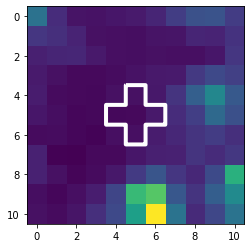

/home/mmarcano/anaconda3/envs/eleanor/lib/python3.7/site-packages/numpy/core/fromnumeric.py:745: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/mmarcano/anaconda3/envs/eleanor/lib/python3.7/site-packages/eleanor/visualize.py:214: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


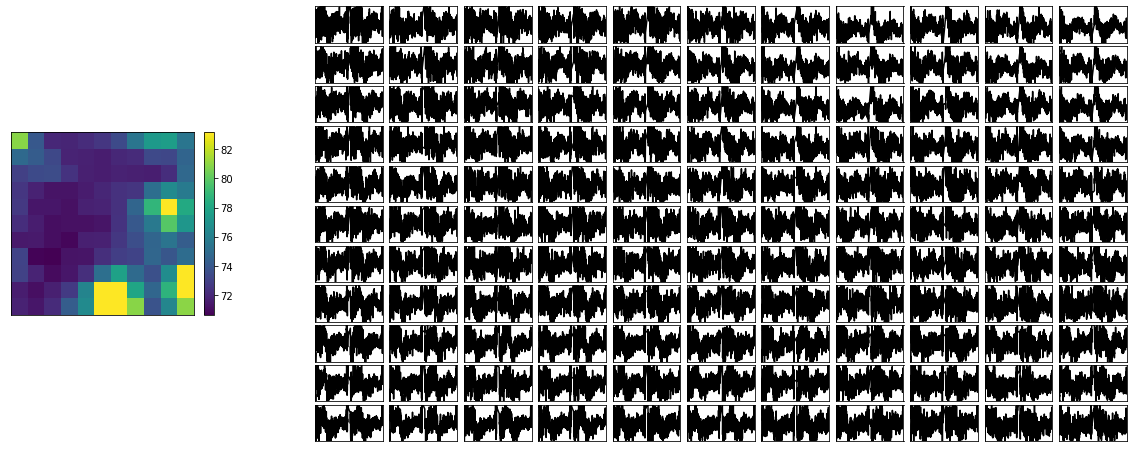

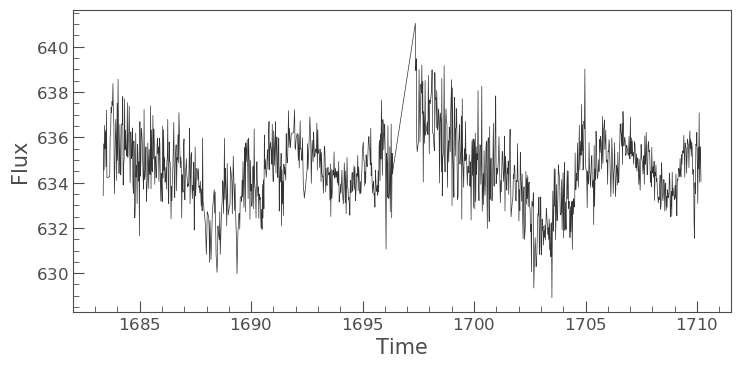

In [12]:
sectornum = 14
star = eleanor.Source(coords=(sourcetess['ra'],sourcetess['dec']), sector=sectornum, tc=True)
dataeleanor = eleanor.TargetData(star,height=11, width=11)

vis = eleanor.Visualize(dataeleanor)
vis.aperture_contour()

fig = vis.pixel_by_pixel()

q = dataeleanor.quality == 0
lkeleanor = LC(dataeleanor.time[q], dataeleanor.corr_flux[q]).plot()

#Bokeh 
lcdic = {'time':dataeleanor.time[q],
        "flatflux":dataeleanor.corr_flux[q]}
source = ColumnDataSource(data=lcdic)

p = figure(plot_width=900, plot_height=500,title='Eleanor Target-BCK {} Sector {}'.format(name,sectornum))
    

#Tool to get wavelength
hover2 = HoverTool(
        tooltips=[
            ('Date', '(@time{0,0.000})')
        ]
    )


p.add_tools(hover2)

p.line('time','flatflux',source=source)
show(p)

# Sector 15

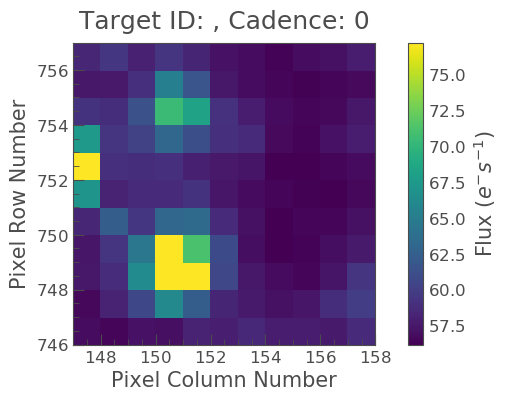

In [30]:
sectornum = 15
#tpf = lk.search_tesscut(sourcecoord,sector=sectornum).download(cutout_size=11)

url = "https://mast.stsci.edu/tesscut/api/v0.1/astrocut?ra={ra}&dec={dec}&y=11&x=11&units=px&sector={sector}".format(ra=sourcetess['ra']
,dec=sourcetess['dec']
,sector=sectornum)
#tpf = lk.search_tesscut(sourcecoord,sector=sectornum).download(cutout_size=11)
response = urllib.request.urlretrieve(url,'TESSCUT.zip')
with ZipFile('TESSCUT.zip') as zipobj:
    zipobj.extractall()
    
for i in glob.glob('tess-s*.fits'):
    os.rename(i,'astrocut.fits')
    tpf = lk.TessTargetPixelFile('astrocut.fits')
    os.remove('astrocut.fits')
    os.remove('TESSCUT.zip')
    



tpf.plot()

In [43]:
from astropy import units as u
from astropy.coordinates import SkyCoord

In [41]:
sourcetess['ra']

262.69829166666665

In [42]:
sourcetess['dec']

55.75513888888889

In [44]:
scalarc = SkyCoord(ra=sourcetess['ra']*u.degree, dec=sourcetess['dec']*u.degree)

In [60]:
ralistall = tpf.get_coordinates()[0]
declistall = tpf.get_coordinates()[1]
ralist = []
declist = []

for i in np.arange(0,11):
    for j in ralist[0]:
        print
    print(ralist[0])


[[262.73830449 262.74151109 262.74471852 262.74792679 262.75113589
  262.75434583 262.7575566  262.76076821 262.76398065 262.76719394
  262.77040805]
 [262.72888785 262.73209335 262.73529969 262.73850686 262.74171486
  262.7449237  262.74813337 262.75134388 262.75455522 262.7577674
  262.76098042]
 [262.71947047 262.72267487 262.72588011 262.72908618 262.73229308
  262.73550082 262.73870939 262.7419188  262.74512904 262.74834012
  262.75155204]
 [262.71005235 262.71325565 262.71645978 262.71966475 262.72287056
  262.7260772  262.72928467 262.73249298 262.73570212 262.7389121
  262.74212292]
 [262.70063348 262.70383568 262.70703872 262.71024259 262.71344729
  262.71665283 262.7198592  262.72306641 262.72627445 262.72948333
  262.73269305]
 [262.69121388 262.69441498 262.69761691 262.70081968 262.70402329
  262.70722772 262.71043299 262.7136391  262.71684604 262.72005382
  262.72326243]
 [262.68179353 262.68499353 262.68819437 262.69139603 262.69459854
  262.69780187 262.70100604 262.704

In [67]:
tpf.get_coordinates(cadence=1)[0][0]

array([262.73830449, 262.74151109, 262.74471852, 262.74792679,
       262.75113589, 262.75434583, 262.7575566 , 262.76076821,
       262.76398065, 262.76719394, 262.77040805])

In [68]:
tpf.get_coordinates(cadence=2)[0][0]

array([262.73830449, 262.74151109, 262.74471852, 262.74792679,
       262.75113589, 262.75434583, 262.7575566 , 262.76076821,
       262.76398065, 262.76719394, 262.77040805])

In [22]:
#If eleanor mask was found can do aperture_mask=data.aperture.astype(bool)

sourcelc = '{}Sector{}withBKLC.fits'.format(name,tpf.sector)
#tpf.interact(notebook_url='localhost:8888',exported_filename=sourcelc)
tpf.interact(notebook_url='localhost:8888',exported_filename=sourcelc,aperture_mask=np.flip(dataeleanor.aperture.astype(bool),0))

In [23]:
tpf.interact_sky(magnitude_limit=20)

In [24]:
background_mask = ~tpf.create_threshold_mask(threshold=0.0000001, reference_pixel=None)
#tpf.plot(aperture_mask=background_mask, mask_color='w');
n_background_pixels = background_mask.sum()
#print(n_background_pixels)
backgroundlc = '{}Sector{}BKLC.fits'.format(name,tpf.sector)

tpf.interact(notebook_url='localhost:8888',exported_filename=backgroundlc,aperture_mask=background_mask)

## Create a light-curve

Number of Background Pixels: 61


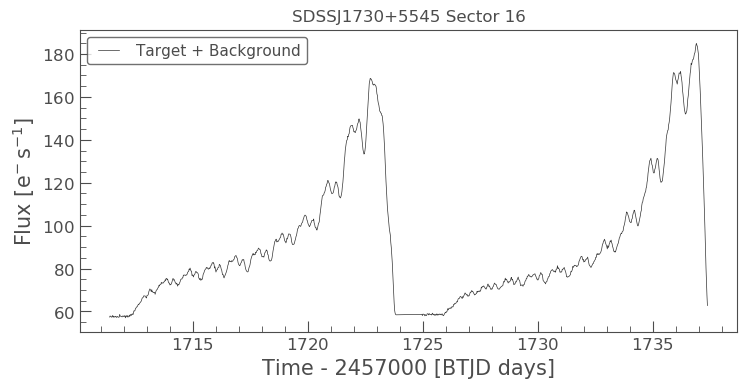

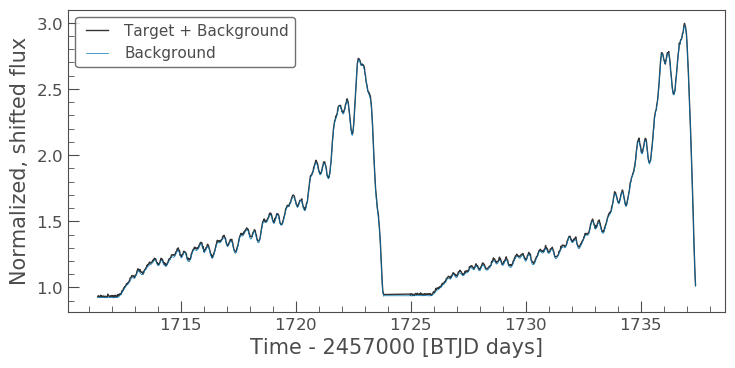

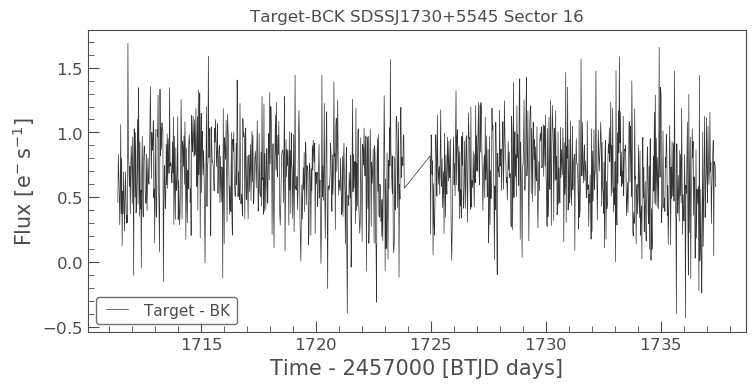

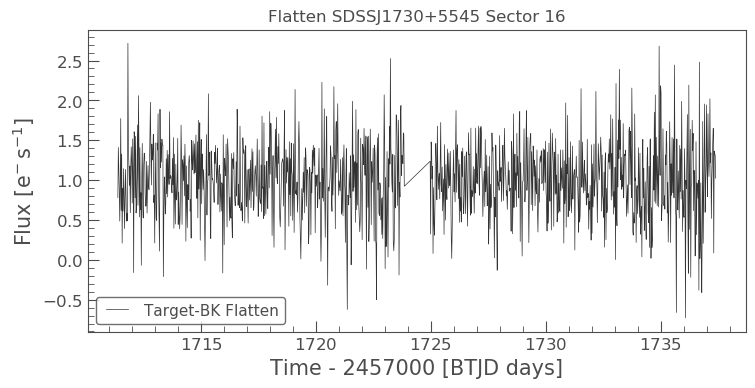

In [29]:
sourcemaskfits = fits.open(sourcelc)
sourcemask = sourcemaskfits[2].data
n_target_pixels = len(np.where(sourcemask==3)[0])

target_lc = tpf.to_lightcurve(aperture_mask=sourcemask)
target_lc.plot(label='Target + Background')
titleplot1 = '{} Sector {}'.format(name,sectornum)
plt.title(titleplot1)


#Backgorund
backgroundmaskfits = fits.open(backgroundlc)
backgroundmask = backgroundmaskfits[2].data
n_background_pixels = len(np.where(backgroundmask==3)[0])
background_lc_per_pixel = tpf.to_lightcurve(aperture_mask=backgroundmask) / n_background_pixels
print("Number of Background Pixels: {}".format(n_background_pixels))
background_estimate_lc = background_lc_per_pixel * n_target_pixels

# Substrtact background
common_normalization = np.nanpercentile(target_lc.flux, 10)
ax = (target_lc / common_normalization).plot(normalize=False, label='Target + Background', lw=1);
(background_estimate_lc / common_normalization +0).plot(ax=ax, normalize=False, label='Background',
                                                        ylabel='Normalized, shifted flux');


corrected_lc = target_lc - background_estimate_lc.flux
corrected_lc.plot(label='Target - BK');
plt.title('Target-BCK {} Sector {}'.format(name,sectornum))


#Remove low frequenbce
flat_lc = corrected_lc.flatten(window_length=401)
flat_lc.plot(label='Target-BK Flatten');
plt.title('Flatten {} Sector {}'.format(name,sectornum))



#Bokeh 
lcdic = {'time':corrected_lc.time,
        "flatflux":corrected_lc.flux}
source = ColumnDataSource(data=lcdic)

p = figure(plot_width=900, plot_height=500,title='Target-BCK {} Sector {}'.format(name,sectornum))
    

#Tool to get wavelength
hover2 = HoverTool(
        tooltips=[
            ('Date', '(@time{0,0.000})')
        ]
    )


p.add_tools(hover2)

p.line('time','flatflux',source=source)
show(p)


# With Eleanor

# Eleanor and tess y axis are flipped

/home/mmarcano/anaconda3/envs/eleanor/lib/python3.7/site-packages/eleanor/targetdata.py:383: UserWarning: WARNING: Making a TPF smaller than (9,9) may provide inadequate results.
  warnings.warn('WARNING: Making a TPF smaller than (9,9) may provide inadequate results.')
/home/mmarcano/anaconda3/envs/eleanor/lib/python3.7/site-packages/eleanor/targetdata.py:393: UserWarning: WARNING: Making a TPF smaller than (9,9) may provide inadequate results.
  warnings.warn('WARNING: Making a TPF smaller than (9,9) may provide inadequate results.')


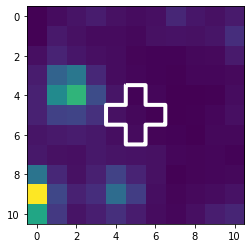

/home/mmarcano/anaconda3/envs/eleanor/lib/python3.7/site-packages/numpy/core/fromnumeric.py:745: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/mmarcano/anaconda3/envs/eleanor/lib/python3.7/site-packages/eleanor/visualize.py:214: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


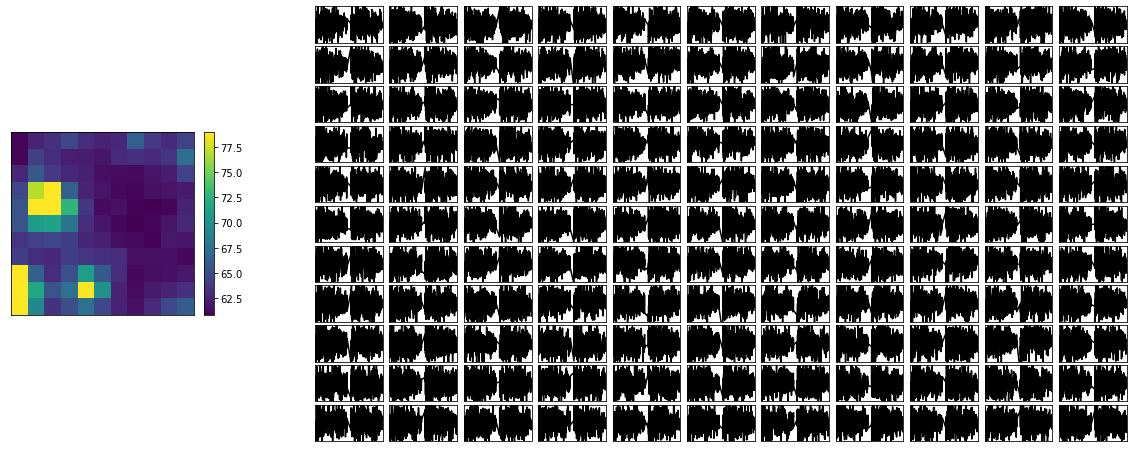

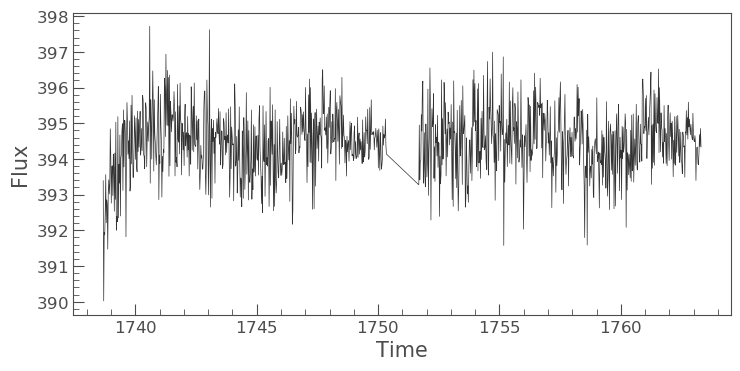

In [27]:
sectornum = 16
star = eleanor.Source(coords=(sourcetess['ra'],sourcetess['dec']), sector=sectornum, tc=True)
dataeleanor = eleanor.TargetData(star,height=11, width=11)

vis = eleanor.Visualize(dataeleanor)
vis.aperture_contour()

fig = vis.pixel_by_pixel()

q = dataeleanor.quality == 0
lkeleanor = LC(dataeleanor.time[q], dataeleanor.corr_flux[q]).plot()

#Bokeh 
lcdic = {'time':dataeleanor.time[q],
        "flatflux":dataeleanor.corr_flux[q]}
source = ColumnDataSource(data=lcdic)

p = figure(plot_width=900, plot_height=500,title='Eleanor Target-BCK {} Sector {}'.format(name,sectornum))
    

#Tool to get wavelength
hover2 = HoverTool(
        tooltips=[
            ('Date', '(@time{0,0.000})')
        ]
    )


p.add_tools(hover2)

p.line('time','flatflux',source=source)
show(p)

# Other Sector

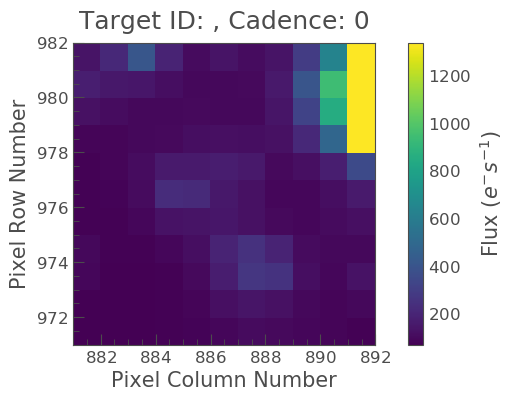

In [228]:
sectornum = 16
#tpf = lk.search_tesscut(sourcecoord,sector=sectornum).download(cutout_size=11)

url = "https://mast.stsci.edu/tesscut/api/v0.1/astrocut?ra={ra}&dec={dec}&y=11&x=11&units=px&sector={sector}".format(ra=sourcetess['ra']
,dec=sourcetess['dec']
,sector=sectornum)
#tpf = lk.search_tesscut(sourcecoord,sector=sectornum).download(cutout_size=11)
response = urllib.request.urlretrieve(url,'TESSCUT.zip')
with ZipFile('TESSCUT.zip') as zipobj:
    zipobj.extractall()
    
for i in glob.glob('tess-s*.fits'):
    os.rename(i,'astrocut.fits')
    tpf = lk.TessTargetPixelFile('astrocut.fits')
    os.remove('astrocut.fits')
    os.remove('TESSCUT.zip')
    



tpf.plot()

In [244]:
#If eleanor mask was found can do aperture_mask=data.aperture.astype(bool)

sourcelc = '{}Sector{}withBKLC.fits'.format(name,tpf.sector)
#tpf.interact(notebook_url='localhost:8888',exported_filename=sourcelc)
tpf.interact(notebook_url='localhost:8888',exported_filename=sourcelc,aperture_mask=np.flip(dataeleanor.aperture.astype(bool),0))

In [245]:
tpf.interact_sky(magnitude_limit=20)

In [242]:
background_mask = ~tpf.create_threshold_mask(threshold=0.0000001, reference_pixel=None)
#tpf.plot(aperture_mask=background_mask, mask_color='w');
n_background_pixels = background_mask.sum()
#print(n_background_pixels)
backgroundlc = '{}Sector{}BKLC.fits'.format(name,tpf.sector)

tpf.interact(notebook_url='localhost:8888',exported_filename=backgroundlc,aperture_mask=background_mask)

## Create a light-curve

Number of Background Pixels: 61


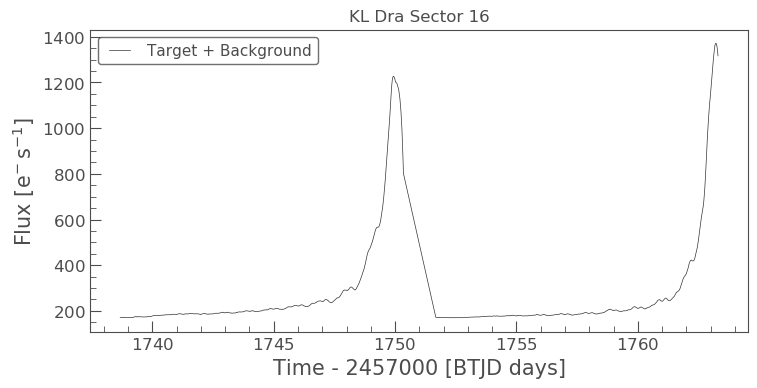

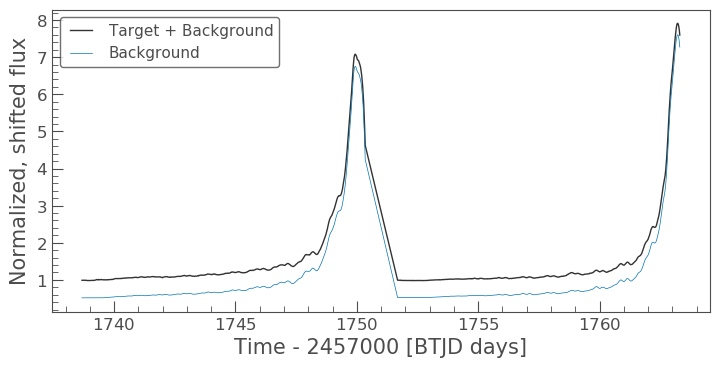

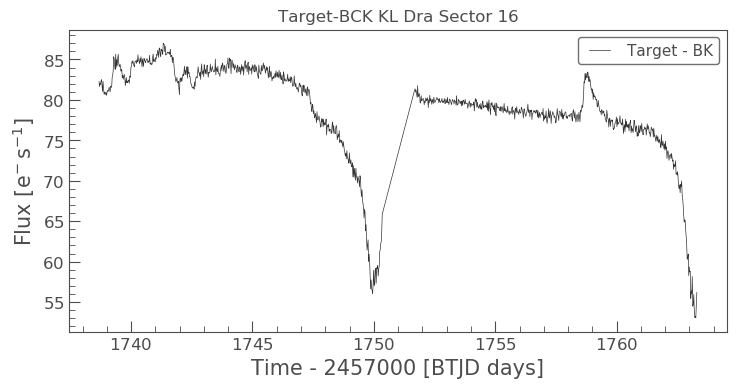

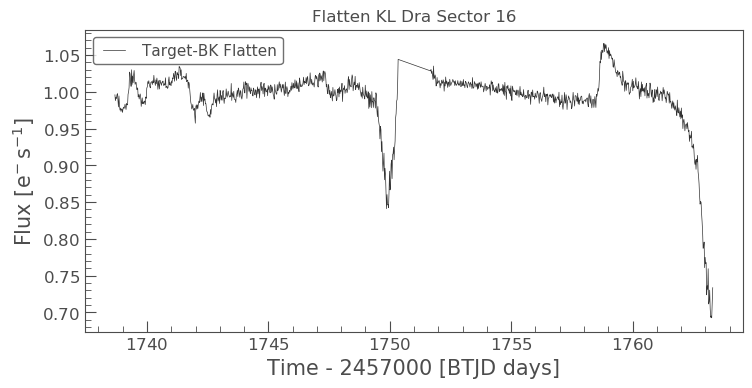

In [253]:
sourcemaskfits = fits.open(sourcelc)
sourcemask = sourcemaskfits[2].data
n_target_pixels = len(np.where(sourcemask==3)[0])

target_lc = tpf.to_lightcurve(aperture_mask=sourcemask)
target_lc.plot(label='Target + Background')
titleplot1 = '{} Sector {}'.format(name,sectornum)
plt.title(titleplot1)


#Backgorund
backgroundmaskfits = fits.open(backgroundlc)
backgroundmask = backgroundmaskfits[2].data
n_background_pixels = len(np.where(backgroundmask==3)[0])
background_lc_per_pixel = tpf.to_lightcurve(aperture_mask=backgroundmask) / n_background_pixels
print("Number of Background Pixels: {}".format(n_background_pixels))
background_estimate_lc = background_lc_per_pixel * n_target_pixels

# Substrtact background
common_normalization = np.nanpercentile(target_lc.flux, 10)
ax = (target_lc / common_normalization).plot(normalize=False, label='Target + Background', lw=1);
(background_estimate_lc / common_normalization +0).plot(ax=ax, normalize=False, label='Background',
                                                        ylabel='Normalized, shifted flux');


corrected_lc = target_lc - background_estimate_lc.flux
corrected_lc.plot(label='Target - BK');
plt.title('Target-BCK {} Sector {}'.format(name,sectornum))


#Remove low frequenbce
flat_lc = corrected_lc.flatten(window_length=401)
flat_lc.plot(label='Target-BK Flatten');
plt.title('Flatten {} Sector {}'.format(name,sectornum))



#Bokeh 
lcdic = {'time':corrected_lc.time,
        "flatflux":corrected_lc.flux}
source = ColumnDataSource(data=lcdic)

p = figure(plot_width=900, plot_height=500,title='Target-BCK {} Sector {}'.format(name,sectornum))
    

#Tool to get wavelength
hover2 = HoverTool(
        tooltips=[
            ('Date', '(@time{0,0.000})')
        ]
    )


p.add_tools(hover2)

p.line('time','flatflux',source=source)
show(p)


# With Eleanor

# Eleanor and tess y axis are flipped

/home/mmarcano/anaconda3/envs/eleanor/lib/python3.7/site-packages/eleanor/targetdata.py:383: UserWarning: WARNING: Making a TPF smaller than (9,9) may provide inadequate results.
  warnings.warn('WARNING: Making a TPF smaller than (9,9) may provide inadequate results.')
/home/mmarcano/anaconda3/envs/eleanor/lib/python3.7/site-packages/eleanor/targetdata.py:393: UserWarning: WARNING: Making a TPF smaller than (9,9) may provide inadequate results.
  warnings.warn('WARNING: Making a TPF smaller than (9,9) may provide inadequate results.')


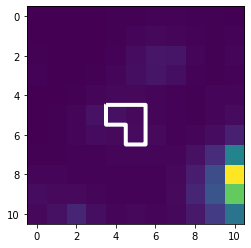

/home/mmarcano/anaconda3/envs/eleanor/lib/python3.7/site-packages/numpy/core/fromnumeric.py:745: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/mmarcano/anaconda3/envs/eleanor/lib/python3.7/site-packages/eleanor/visualize.py:214: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


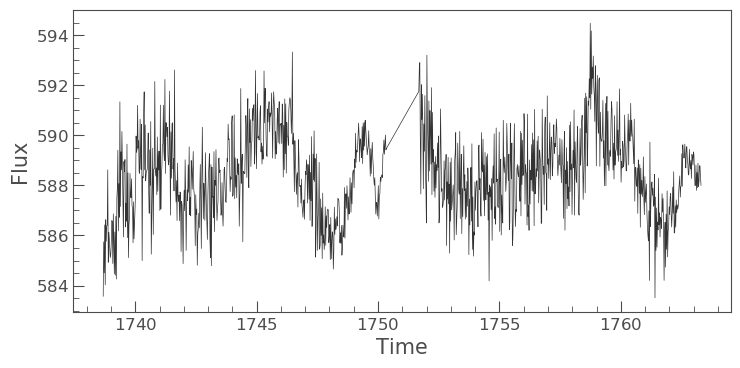

In [239]:
sectornum = 16
star = eleanor.Source(coords=(sourcetess['ra'],sourcetess['dec']), sector=sectornum, tc=True)
dataeleanor = eleanor.TargetData(star,height=11, width=11)

vis = eleanor.Visualize(dataeleanor)
vis.aperture_contour()

fig = vis.pixel_by_pixel()

%matplotlib inline
q = dataeleanor.quality == 0
lkeleanor = LC(dataeleanor.time[q], dataeleanor.corr_flux[q]).plot()

#Bokeh 
lcdic = {'time':dataeleanor.time[q],
        "flatflux":dataeleanor.corr_flux[q]}
source = ColumnDataSource(data=lcdic)

p = figure(plot_width=900, plot_height=500,title='Eleanor Target-BCK {} Sector {}'.format(name,sectornum))
    

#Tool to get wavelength
hover2 = HoverTool(
        tooltips=[
            ('Date', '(@time{0,0.000})')
        ]
    )


p.add_tools(hover2)

p.line('time','flatflux',source=source)
show(p)

/home/mmarcano/anaconda3/envs/eleanor/lib/python3.7/site-packages/numpy/core/fromnumeric.py:745: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/mmarcano/anaconda3/envs/eleanor/lib/python3.7/site-packages/eleanor/visualize.py:214: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


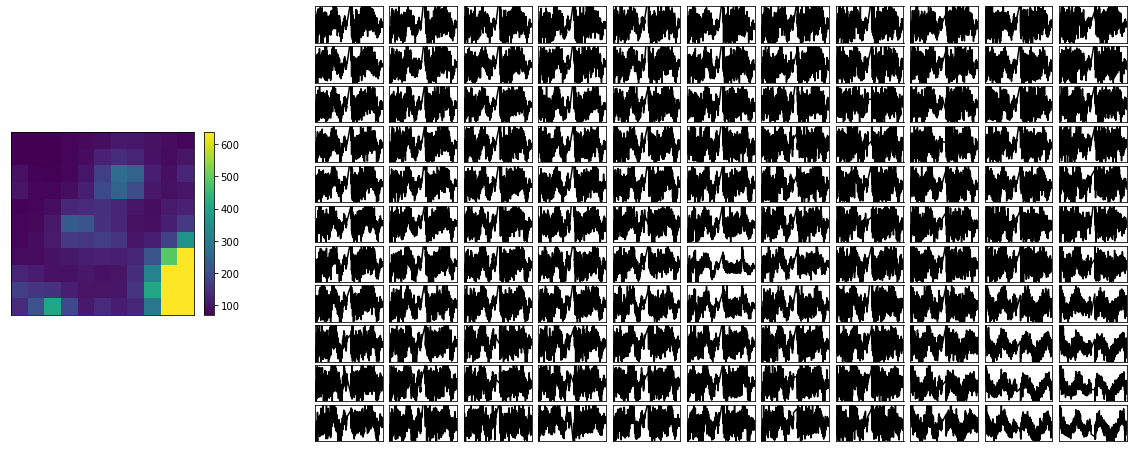

In [240]:
fig = vis.pixel_by_pixel()

# SEctor 17

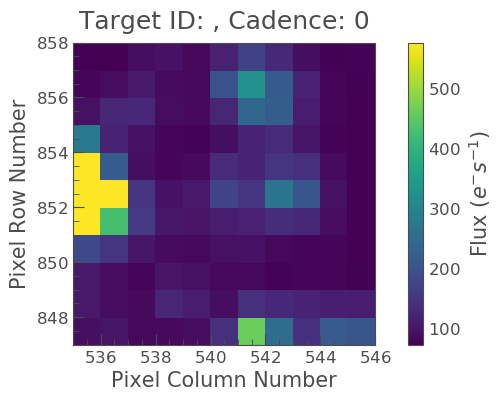

In [285]:
sectornum = 17
#tpf = lk.search_tesscut(sourcecoord,sector=sectornum).download(cutout_size=11)

url = "https://mast.stsci.edu/tesscut/api/v0.1/astrocut?ra={ra}&dec={dec}&y=11&x=11&units=px&sector={sector}".format(ra=sourcetess['ra']
,dec=sourcetess['dec']
,sector=sectornum)
#tpf = lk.search_tesscut(sourcecoord,sector=sectornum).download(cutout_size=11)
response = urllib.request.urlretrieve(url,'TESSCUT.zip')
with ZipFile('TESSCUT.zip') as zipobj:
    zipobj.extractall()
    
for i in glob.glob('tess-s*.fits'):
    os.rename(i,'astrocut.fits')
    tpf = lk.TessTargetPixelFile('astrocut.fits')
    os.remove('astrocut.fits')
    os.remove('TESSCUT.zip')
    



tpf.plot()

In [255]:
#If eleanor mask was found can do aperture_mask=data.aperture.astype(bool)

sourcelc = '{}Sector{}withBKLC.fits'.format(name,tpf.sector)
#tpf.interact(notebook_url='localhost:8888',exported_filename=sourcelc)
tpf.interact(notebook_url='localhost:8888',exported_filename=sourcelc,aperture_mask=dataeleanor.aperture.astype(bool))

In [256]:
tpf.interact_sky(magnitude_limit=20)

In [294]:
background_mask = ~tpf.create_threshold_mask(threshold=0.0000001, reference_pixel=None)
#tpf.plot(aperture_mask=background_mask, mask_color='w');
n_background_pixels = background_mask.sum()
#print(n_background_pixels)
backgroundlc = '{}Sector{}BKLC.fits'.format(name,tpf.sector)

tpf.interact(notebook_url='localhost:8888',exported_filename=backgroundlc,aperture_mask=background_mask)

## Create a light-curve

Number of Background Pixels: 61


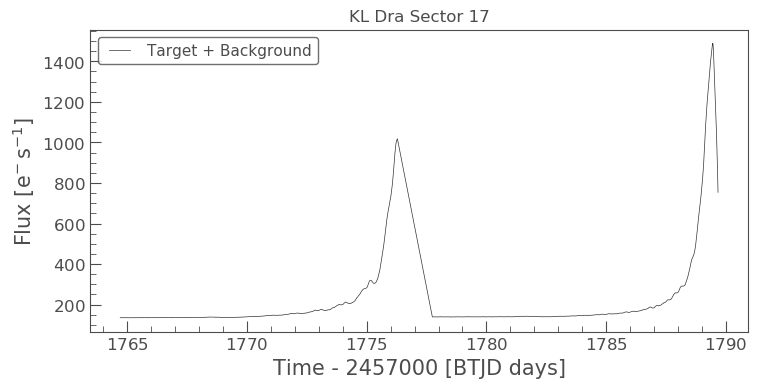

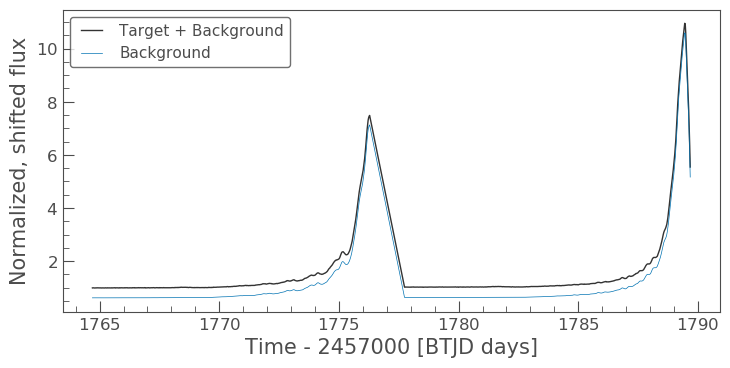

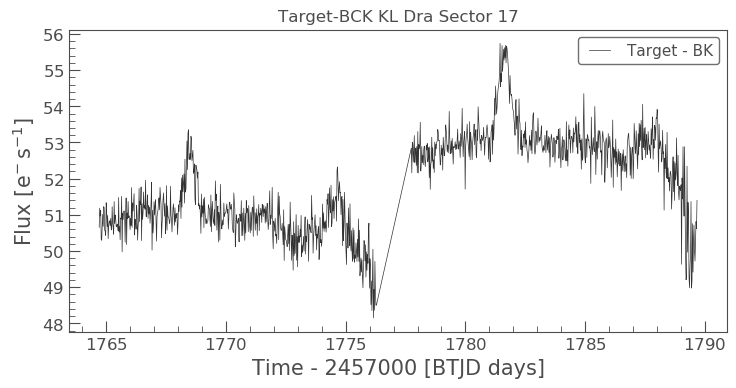

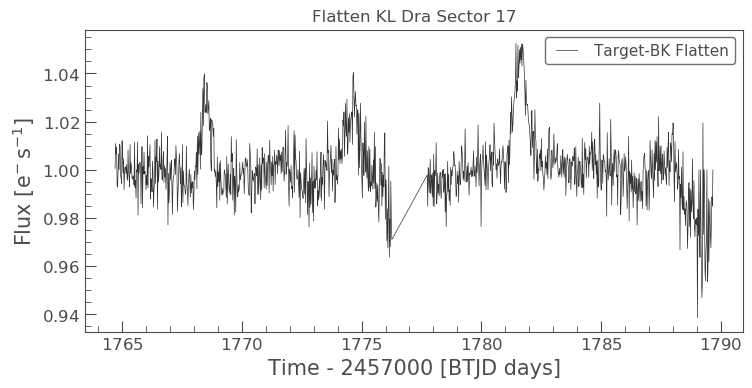

In [295]:
sourcemaskfits = fits.open(sourcelc)
sourcemask = sourcemaskfits[2].data
n_target_pixels = len(np.where(sourcemask==3)[0])

target_lc = tpf.to_lightcurve(aperture_mask=sourcemask)
target_lc.plot(label='Target + Background')
titleplot1 = '{} Sector {}'.format(name,sectornum)
plt.title(titleplot1)


#Backgorund
backgroundmaskfits = fits.open(backgroundlc)
backgroundmask = backgroundmaskfits[2].data
n_background_pixels = len(np.where(backgroundmask==3)[0])
background_lc_per_pixel = tpf.to_lightcurve(aperture_mask=backgroundmask) / n_background_pixels
print("Number of Background Pixels: {}".format(n_background_pixels))
background_estimate_lc = background_lc_per_pixel * n_target_pixels

# Substrtact background
common_normalization = np.nanpercentile(target_lc.flux, 10)
ax = (target_lc / common_normalization).plot(normalize=False, label='Target + Background', lw=1);
(background_estimate_lc / common_normalization +0).plot(ax=ax, normalize=False, label='Background',
                                                        ylabel='Normalized, shifted flux');


corrected_lc = target_lc - background_estimate_lc.flux
corrected_lc.plot(label='Target - BK');
plt.title('Target-BCK {} Sector {}'.format(name,sectornum))


#Remove low frequenbce
flat_lc = corrected_lc.flatten(window_length=401)
flat_lc.plot(label='Target-BK Flatten');
plt.title('Flatten {} Sector {}'.format(name,sectornum))



#Bokeh 
lcdic = {'time':corrected_lc.time,
        "flatflux":corrected_lc.flux}
source = ColumnDataSource(data=lcdic)

p = figure(plot_width=900, plot_height=500,title='Target-BCK {} Sector {}'.format(name,sectornum))
    

#Tool to get wavelength
hover2 = HoverTool(
        tooltips=[
            ('Date', '(@time{0,0.000})')
        ]
    )


p.add_tools(hover2)

p.line('time','flatflux',source=source)
show(p)


# With Eleanor

# Eleanor and tess y axis are flipped

In [265]:
sectornum = 17
star = eleanor.Source(coords=(sourcetess['ra'],sourcetess['dec']), sector=sectornum, tc=False)
dataeleanor = eleanor.TargetData(star,height=11, width=11)

SearchError: Sorry, this sector isn't available yet. We're working on it!

In [ ]:
vis = eleanor.Visualize(dataeleanor)
vis.aperture_contour()

In [ ]:
fig = vis.pixel_by_pixel()

In [ ]:
cross = eleanor.Crossmatch(dataeleanor)


In [ ]:
cross.two_minute()

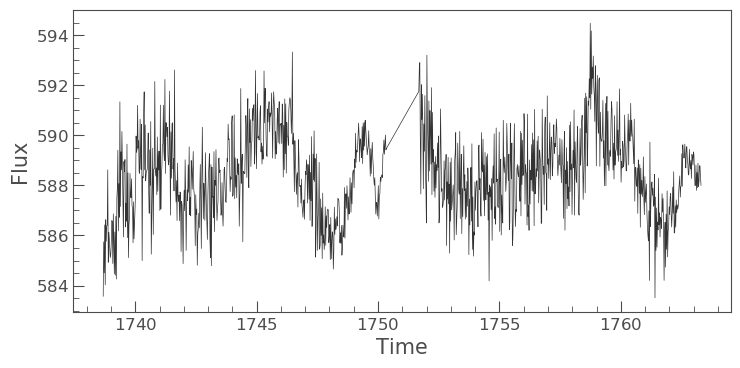

In [91]:
%matplotlib inline
q = dataeleanor.quality == 0
lkeleanor = LC(dataeleanor.time[q], dataeleanor.corr_flux[q]).plot()

#Bokeh 
lcdic = {'time':dataeleanor.time[q],
        "flatflux":dataeleanor.corr_flux[q]}
source = ColumnDataSource(data=lcdic)

p = figure(plot_width=900, plot_height=500,title='Eleanor Target-BCK {} Sector {}'.format(name,sectornum))
    

#Tool to get wavelength
hover2 = HoverTool(
        tooltips=[
            ('Date', '(@time{0,0.000})')
        ]
    )


p.add_tools(hover2)

p.line('time','flatflux',source=source)
show(p)

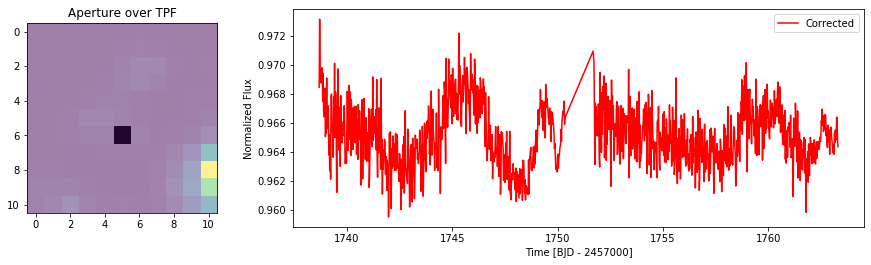

In [103]:
dataeleanor.get_lightcurve(aperture=sourcemask)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,4), gridspec_kw={'width_ratios':[1,3]})
ax1.imshow(dataeleanor.tpf[0])
ax1.imshow(sourcemask, cmap='Greys', alpha=0.5)
ax1.set_title('Aperture over TPF')
#plt.imshow(dataeleanor.aperture)

#ax2.plot(dataeleanor.time[q], dataeleanor.raw_flux[q]/np.nanmedian(dataeleanor.raw_flux[q]), 'k', label='Raw')
ax2.plot(dataeleanor.time[q], dataeleanor.corr_flux[q]/np.nanmedian(dataeleanor.corr_flux[q]) - 0.035, 'r', label='Corrected')
ax2.legend()
ax2.set_xlabel('Time [BJD - 2457000]')
ax2.set_ylabel('Normalized Flux');

# Sector 18 

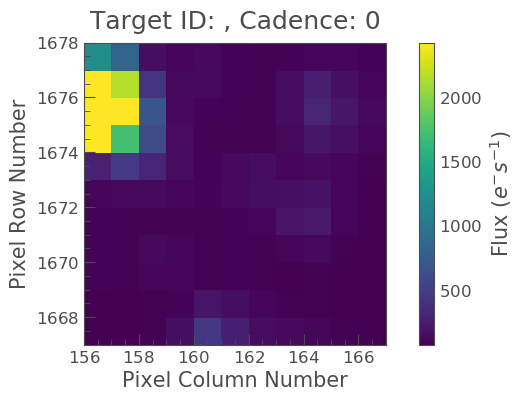

In [266]:
sectornum = 18
#tpf = lk.search_tesscut(sourcecoord,sector=sectornum).download(cutout_size=11)

url = "https://mast.stsci.edu/tesscut/api/v0.1/astrocut?ra={ra}&dec={dec}&y=11&x=11&units=px&sector={sector}".format(ra=sourcetess['ra']
,dec=sourcetess['dec']
,sector=sectornum)
#tpf = lk.search_tesscut(sourcecoord,sector=sectornum).download(cutout_size=11)
response = urllib.request.urlretrieve(url,'TESSCUT.zip')
with ZipFile('TESSCUT.zip') as zipobj:
    zipobj.extractall()
    
for i in glob.glob('tess-s*.fits'):
    os.rename(i,'astrocut.fits')
    tpf = lk.TessTargetPixelFile('astrocut.fits')
    os.remove('astrocut.fits')
    os.remove('TESSCUT.zip')
    



tpf.plot()

In [267]:
#If eleanor mask was found can do aperture_mask=data.aperture.astype(bool)

sourcelc = '{}Sector{}withBKLC.fits'.format(name,tpf.sector)
#tpf.interact(notebook_url='localhost:8888',exported_filename=sourcelc)
tpf.interact(notebook_url='localhost:8888',exported_filename=sourcelc,aperture_mask=dataeleanor.aperture.astype(bool))

In [268]:
tpf.interact_sky(magnitude_limit=20)

In [279]:
background_mask = ~tpf.create_threshold_mask(threshold=0.0000001, reference_pixel=None)
#tpf.plot(aperture_mask=background_mask, mask_color='w');
n_background_pixels = background_mask.sum()
#print(n_background_pixels)
backgroundlc = '{}Sector{}BKLC.fits'.format(name,tpf.sector)

tpf.interact(notebook_url='localhost:8888',exported_filename=backgroundlc,aperture_mask=background_mask)

## Create a light-curve

Number of Background Pixels: 4


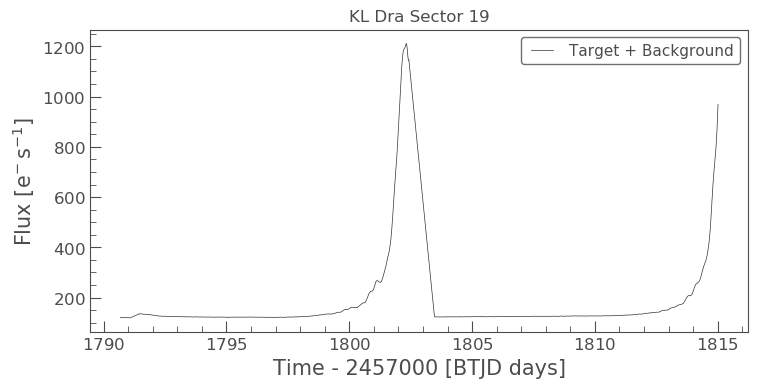

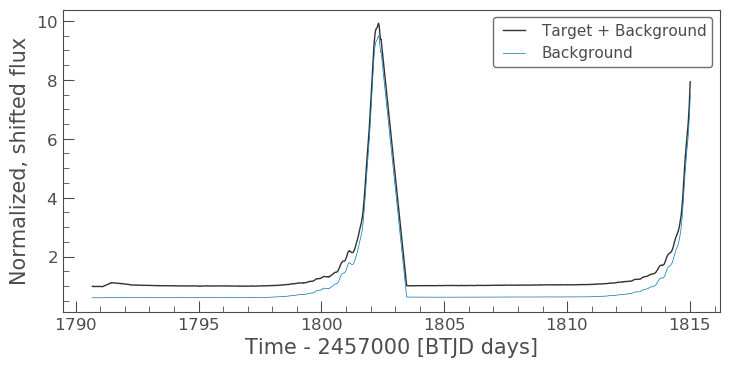

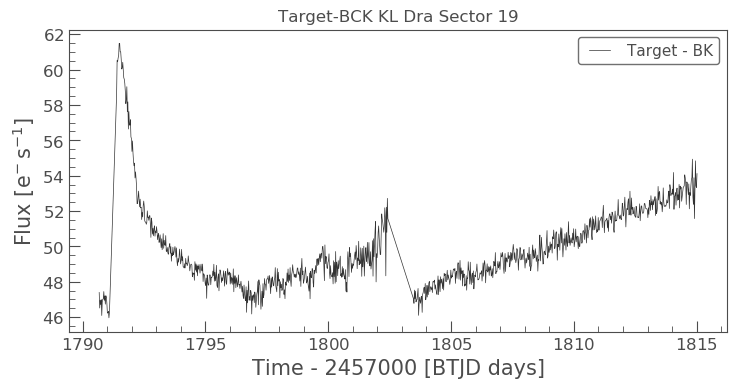

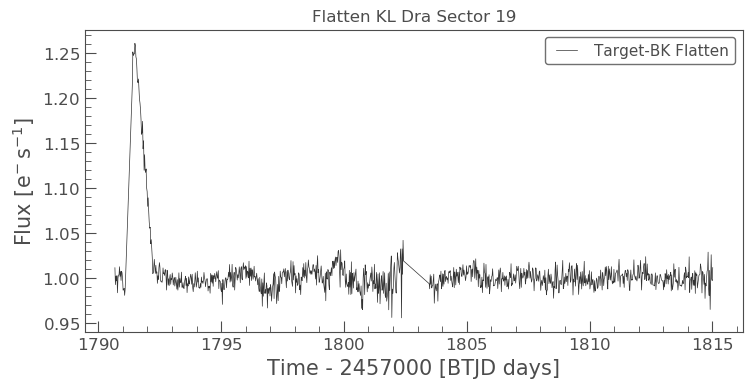

In [283]:
sourcemaskfits = fits.open(sourcelc)
sourcemask = sourcemaskfits[2].data
n_target_pixels = len(np.where(sourcemask==3)[0])

target_lc = tpf.to_lightcurve(aperture_mask=sourcemask)
target_lc.plot(label='Target + Background')
titleplot1 = '{} Sector {}'.format(name,sectornum)
plt.title(titleplot1)


#Backgorund
backgroundmaskfits = fits.open(backgroundlc)
backgroundmask = backgroundmaskfits[2].data
n_background_pixels = len(np.where(backgroundmask==3)[0])
background_lc_per_pixel = tpf.to_lightcurve(aperture_mask=backgroundmask) / n_background_pixels
print("Number of Background Pixels: {}".format(n_background_pixels))
background_estimate_lc = background_lc_per_pixel * n_target_pixels

# Substrtact background
common_normalization = np.nanpercentile(target_lc.flux, 10)
ax = (target_lc / common_normalization).plot(normalize=False, label='Target + Background', lw=1);
(background_estimate_lc / common_normalization +0).plot(ax=ax, normalize=False, label='Background',
                                                        ylabel='Normalized, shifted flux');


corrected_lc = target_lc - background_estimate_lc.flux
corrected_lc.plot(label='Target - BK');
plt.title('Target-BCK {} Sector {}'.format(name,sectornum))


#Remove low frequenbce
flat_lc = corrected_lc.flatten(window_length=401)
flat_lc.plot(label='Target-BK Flatten');
plt.title('Flatten {} Sector {}'.format(name,sectornum))



#Bokeh 
lcdic = {'time':corrected_lc.time,
        "flatflux":corrected_lc.flux}
source = ColumnDataSource(data=lcdic)

p = figure(plot_width=900, plot_height=500,title='Target-BCK {} Sector {}'.format(name,sectornum))
    

#Tool to get wavelength
hover2 = HoverTool(
        tooltips=[
            ('Date', '(@time{0,0.000})')
        ]
    )


p.add_tools(hover2)

p.line('time','flatflux',source=source)
show(p)


In [281]:
sectornum = 18
star = eleanor.Source(coords=(sourcetess['ra'],sourcetess['dec']), sector=sectornum, tc=False)
dataeleanor = eleanor.TargetData(star,height=11, width=11)

SearchError: Sorry, this sector isn't available yet. We're working on it!

# SEctor 19

In [282]:
sectornum = 19
#tpf = lk.search_tesscut(sourcecoord,sector=sectornum).download(cutout_size=11)

url = "https://mast.stsci.edu/tesscut/api/v0.1/astrocut?ra={ra}&dec={dec}&y=11&x=11&units=px&sector={sector}".format(ra=sourcetess['ra']
,dec=sourcetess['dec']
,sector=sectornum)
#tpf = lk.search_tesscut(sourcecoord,sector=sectornum).download(cutout_size=11)
response = urllib.request.urlretrieve(url,'TESSCUT.zip')
with ZipFile('TESSCUT.zip') as zipobj:
    zipobj.extractall()
    
for i in glob.glob('tess-s*.fits'):
    os.rename(i,'astrocut.fits')
    tpf = lk.TessTargetPixelFile('astrocut.fits')
    os.remove('astrocut.fits')
    os.remove('TESSCUT.zip')
    



tpf.plot()

HTTPError: HTTP Error 400: Bad Request: Malformed sector parameter